# AlexNet

[Paper here](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)


In [1]:
from rich import print
from tqdm.notebook import tqdm
%load_ext rich


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
import mlflow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.enable_system_metrics_logging()


In [4]:
# Hyperparameters

BATCH_SIZE = 128
N_EPOCHS = 90
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
N_CLASSES = 10

## Load the dataset


In [5]:
true_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


In [6]:
train_dataset = CIFAR10(
    root="./data/", download=True, train=True, transform=transforms.ToTensor()
)
test_dataset = CIFAR10(
    root="./data/", download=True, train=False, transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
mean_pixel_train = train_dataset.data.mean(axis=(0, 1, 2)) / 255
std_pixel_train = train_dataset.data.std(axis=(0, 1, 2)) / 255

mean_pixel_test = test_dataset.data.mean(axis=(0, 1, 2)) / 255
std_pixel_test = test_dataset.data.std(axis=(0, 1, 2)) / 255

(mean_pixel_train, std_pixel_train), (mean_pixel_test, std_pixel_test)



(
    (array([0.49139968, 0.48215841, 0.44653091]), array([0.24703223, 0.24348513, 0.26158784])),
    (array([0.49421428, 0.48513139, 0.45040909]), array([0.24665252, 0.24289226, 0.26159238]))
)

In [8]:
train_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_pixel_train, std_pixel_train),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_pixel_test, std_pixel_test),
    ]
)

In [9]:
def reverse_transform(x, train=True):
    mean_pixel, std_pixel = (
        mean_pixel_train if train else mean_pixel_test,
        std_pixel_train if train else std_pixel_test,
    )

    x = x * torch.tensor(std_pixel).view(3, 1, 1) + torch.tensor(mean_pixel).view(
        3, 1, 1
    )

    x = transforms.ToPILImage()(x)

    return x

In [10]:
full_train_dataset = CIFAR10(
    root="./data/", download=True, train=True, transform=train_transform
)

test_dataset = CIFAR10(
    root="./data/", download=True, train=False, transform=test_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Calculate the sizes for training and validation datasets (70-30 split)
train_size = int(0.7 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the full training dataset into training and validation datasets
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


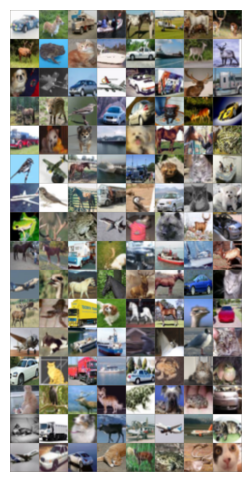

In [13]:
images, _ = next(iter(train_loader))
grid = make_grid(images, nrow=8)

plt.figure(figsize=(16, 6))
plt.imshow(reverse_transform(grid, train=True))
plt.axis("off")
plt.show()


## Build the architecture


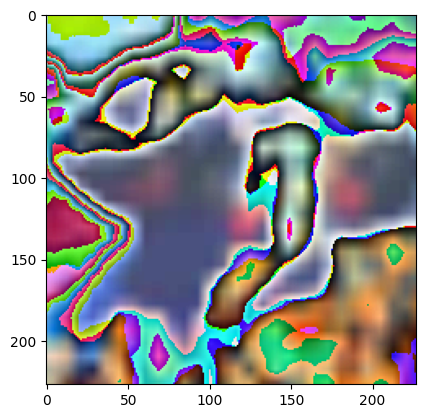

torch.Size([3, 227, 227])

6 frog

In [14]:
sample_image, sample_label = train_loader.dataset[1]
plt.imshow(transforms.ToPILImage()(sample_image))
plt.show()
print(sample_image.shape)
print(sample_label, true_labels[sample_label])

In [15]:
class AlexNet(nn.Module):
    def __init__(self, n_classes: int = 10, debug: bool = False):
        super().__init__()
        self.debug = debug
        self.n_classes = n_classes

        # B x 3 x 227 x 227 -> B x 96 x 27 x 27
        self.layer1 = nn.Sequential(
            # B x 3 x 227 x 227 -> B x 96 x 55 x 55
            nn.Conv2d(
                in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0
            ),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            # B x 96 x 55 x 55 -> B x 96 x 27 x 27
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # B x 96 x 27 x 27 -> B x 256 x 13 x 13
        self.layer2 = nn.Sequential(
            # B x 96 x 27 x 27 -> B x 256 x 27 x 27
            nn.Conv2d(
                in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2
            ),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # B x 256 x 27 x 27 -> B x 256 x 13 x 13
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # B x 256 x 13 x 13 -> B x 384 x 13 x 13
        self.layer3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(384),
        )

        # B x 384 x 13 x 13 -> B x 384 x 13 x 13
        self.layer4 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(384),
        )

        # B x 384 x 13 x 13 -> B x 256 x 6 x 6
        self.layer5 = nn.Sequential(
            # B x 384 x 13 x 13 -> B x 256 x 13 x 13
            nn.Conv2d(
                in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # B x 256 x 13 x 13 -> B x 256 x 6 x 6
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # B x 256 x 6 x 6 -> B x 4096
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
        )

        # B x 4096 -> B x 4096
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
        )

        # B x 4096 -> # B x N_CLASSES
        self.fc3 = nn.Linear(4096, self.n_classes)

        self._init_layers()

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def _init_layers(self):
        for layer in self.children():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                # Initializing weights with mean=0, std=0.01
                nn.init.normal_(layer.weight, mean=0, std=0.01)

                if isinstance(layer, nn.Conv2d):
                    # Initializing bias with 0 for conv layers
                    nn.init.constant_(layer.bias, 0)
                elif isinstance(layer, nn.Linear):
                    # Initializing bias with 1 for linear layers
                    nn.init.constant_(layer.bias, 1)

        # Original paper mentions setting bias for 2nd, 4th and 5th conv layers to 1
        nn.init.constant_(self.layer2[0].bias, 1)
        nn.init.constant_(self.layer4[0].bias, 1)
        nn.init.constant_(self.layer5[0].bias, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._debug_print(x, "Input")
        x = self.layer1(x)
        self._debug_print(x, "Layer1")
        x = self.layer2(x)
        self._debug_print(x, "Layer2")
        x = self.layer3(x)
        self._debug_print(x, "Layer3")
        x = self.layer4(x)
        self._debug_print(x, "Layer4")
        x = self.layer5(x)
        self._debug_print(x, "Layer5")
        x = x.reshape(x.size(0), -1)
        self._debug_print(x, "Resized")
        x = self.fc1(x)
        self._debug_print(x, "FC1")
        x = self.fc2(x)
        self._debug_print(x, "FC2")
        x = self.fc3(x)
        self._debug_print(x, "Output")

        return x


In [16]:
model = AlexNet(debug=True)
x = model(sample_image.unsqueeze(0))


Input: torch.Size([1, 3, 227, 227])

Layer1: torch.Size([1, 96, 27, 27])

Layer2: torch.Size([1, 256, 13, 13])

Layer3: torch.Size([1, 384, 13, 13])

Layer4: torch.Size([1, 384, 13, 13])

Layer5: torch.Size([1, 256, 6, 6])

Resized: torch.Size([1, 9216])

FC1: torch.Size([1, 4096])

FC2: torch.Size([1, 4096])

Output: torch.Size([1, 10])

In [17]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 58325066

## Train the model

In [18]:
model = AlexNet(n_classes=N_CLASSES, debug=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=10
)

In [19]:
mlflow.set_experiment(experiment_name="lenet5")

<Experiment: artifact_location='mlflow-artifacts:/135445217893204646', creation_time=1721227995909, experiment_id='135445217893204646', last_update_time=1721227995909, lifecycle_stage='active', name='lenet5', tags={}>

In [20]:
# with mlflow.start_run() as run:
# run_id = run.info.run_id
# Log hyperparameters
# mlflow.log_params(
#     {
#         "N_EPOCHS": N_EPOCHS,
#         "LEARNING_RATE": LEARNING_RATE,
#         "BATCH_SIZE": BATCH_SIZE,
#         "Optimizer": optimizer.__class__.__name__,
#         "Loss Function": criterion.__class__.__name__,
#     }
# )

for epoch in tqdm(range(10)):
    # ---------- Training ----------
    train_loss = 0

    for batch, (inputs, labels) in enumerate(train_loader):
        model.train()

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f}')
    # mlflow.log_metric("train_loss", train_loss, step=epoch)

    # ---------- Validation ----------

    val_loss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.inference_mode():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss += criterion(outputs, labels)

            total += labels.size(0)
            correct += (labels == outputs.argmax(dim=-1)).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total
        scheduler.step(val_loss)

        print(f'Epoch: {epoch} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}')

#     mlflow.log_metric("val_loss", val_loss, step=epoch)
#     mlflow.log_metric("val_acc", val_acc, step=epoch)

# mlflow.pytorch.log_model(model, "model")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.5218

Epoch: 0 | Val Loss: 1.2819 | Val Acc: 53.77%

Epoch: 1 | Train Loss: 1.1455

Epoch: 1 | Val Loss: 1.1300 | Val Acc: 59.66%

Epoch: 2 | Train Loss: 0.9592

Epoch: 2 | Val Loss: 1.0186 | Val Acc: 64.43%

Epoch: 3 | Train Loss: 0.8294

Epoch: 3 | Val Loss: 0.7860 | Val Acc: 72.65%

Epoch: 4 | Train Loss: 0.7272

Epoch: 4 | Val Loss: 0.7723 | Val Acc: 72.74%

Epoch: 5 | Train Loss: 0.6587

Epoch: 5 | Val Loss: 0.7047 | Val Acc: 75.47%

Epoch: 6 | Train Loss: 0.5976

Epoch: 6 | Val Loss: 0.6673 | Val Acc: 77.19%

Epoch: 7 | Train Loss: 0.5450

Epoch: 7 | Val Loss: 0.6451 | Val Acc: 77.63%

Epoch: 8 | Train Loss: 0.5004

Epoch: 8 | Val Loss: 0.6394 | Val Acc: 77.49%

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:18                                                                                   │
│                                                                                                  │
│   15 │   # ---------- Training ----------                                                        │
│   16 │   train_loss = 0                                                                          │
│   17 │                                                                                           │
│ ❱ 18 │   for batch, (inputs, labels) in enumerate(train_loader):                                 │
│   19 │   │   model.train()                                                                       │
│   20 │   │                                                                                       │
│   21 │   │   inputs, labels = inputs.to(device), labels.to(device)                               │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\utils\data\dataloader.py:631 in  │
│ __next__                                                                                         │
│                                                                                                  │
│    628 │   │   │   if self._sampler_iter is None:                                                │
│    629 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    630 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  631 │   │   │   data = self._next_data()                                                      │
│    632 │   │   │   self._num_yielded += 1                                                        │
│    633 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    634 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\utils\data\dataloader.py:675 in  │
│ _next_data                                                                                       │
│                                                                                                  │
│    672 │                                                                                         │
│    673 │   def _next_data(self):                                                                 │
│    674 │   │   index = self._next_index()  # may raise StopIteration                             │
│ ❱  675 │   │   data = self._dataset_fetcher.fetch(index)  # may raise StopIteration              │
│    676 │   │   if self._pin_memory:                                                              │
│    677 │   │   │   data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)            │
│    678 │   │   return data                                                                       │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\utils\data\_utils\fetch.py:49 in │
│ fetch                                                                                            │
│                                                                                                  │
│   46 │   def fetch(self, possibly_batched_index):                                                │
│   47 │   │   if self.auto_collation:                                                             │
│   48 │   │   │   if hasattr(self.dataset, "__getitems__") and self.dataset.__getitems__:         │
│ ❱ 49 │   │   │   │   data = self.dataset.__getitems__(possi

## Test the model

In [45]:
model.eval()

test_loss = 0
correct = 0
total = 0
# with mlflow.start_run(run_id=run_id):
with torch.inference_mode():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        test_loss += criterion(outputs, labels)

        total += labels.size(0)
        correct += (labels == outputs.argmax(dim=-1)).sum().item()

    test_loss /= len(test_loader)
    test_acc = correct / total

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%}")

# mlflow.log_metric("test_loss", test_loss)
# mlflow.log_metric("test_acc", test_acc)

Test Loss: 0.8026 | Test Acc: 72.82%

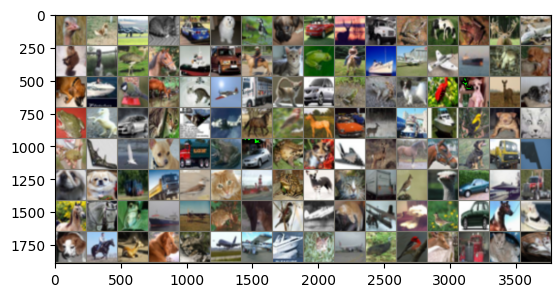

Index     Predicted Actual

0         bird      bird

1         cat       dog

2         airplane  airplane

3         cat       cat

4         automobileautomobile

5         dog       dog

6         bird      bird

7         dog       dog

8         automobileautomobile

9         airplane  deer

10        automobiletruck

11        frog      frog

12        dog       horse

13        frog      frog

14        deer      deer

15        airplane  airplane

16        bird      cat

17        dog       bird

18        deer      bird

19        horse     horse

20        ship      ship

21        automobileautomobile

22        horse     horse

23        cat       cat

24        frog      frog

25        horse     horse

26        ship      ship

27        airplane  airplane

28        airplane  airplane

29        ship      ship

30        truck     deer

31        frog      dog

32        airplane  dog

33        ship      ship

34        airplane  bird

35        truck     deer

36        airplane  cat

37        airplane  airplane

38        truck     truck

39        cat       cat

40        automobileautomobile

41        frog      frog

42        frog      frog

43        dog       dog

44        bird      bird

45        dog       dog

46        deer      deer

47        cat       cat

48        frog      frog

49        airplane  horse

50        automobileautomobile

51        bird      cat

52        airplane  airplane

53        airplane  airplane

54        horse     horse

55        bird      bird

56        airplane  horse

57        automobileautomobile

58        deer      deer

59        ship      truck

60        ship      ship

61        bird      bird

62        dog       dog

63        airplane  cat

64        airplane  frog

65        ship      airplane

66        ship      bird

67        dog       dog

68        truck     truck

69        frog      frog

70        automobileautomobile

71        frog      frog

72        dog       cat

73        airplane  airplane

74        deer      deer

75        horse     horse

76        airplane  horse

77        bird      dog

78        truck     truck

79        ship      airplane

80        horse     dog

81        dog       dog

82        truck     truck

83        truck     truck

84        airplane  bird

85        cat       cat

86        ship      ship

87        frog      frog

88        deer      dog

89        cat       cat

90        truck     truck

91        bird      bird

92        bird      bird

93        automobileautomobile

94        ship      airplane

95        truck     truck

96        airplane  horse

97        truck     horse

98        cat       frog

99        ship      ship

100       airplane  airplane

101       frog      frog

102       deer      horse

103       bird      bird

104       ship      airplane

105       cat       cat

106       airplane  airplane

107       ship      dog

108       airplane  bird

109       automobileautomobile

110       dog       horse

111       ship      ship

112       dog       dog

113       horse     horse

114       airplane  deer

115       cat       dog

116       frog      cat

117       airplane  airplane

118       airplane  airplane

119       ship      ship

120       frog      cat

121       airplane  airplane

122       bird      bird

123       bird      bird

124       deer      deer

125       airplane  truck

126       cat       cat

127       ship      cat

In [52]:
sample_test_images, sample_test_labels = next(iter(test_loader))

plt.imshow(
    reverse_transform(make_grid(sample_test_images, nrow=16, padding=8, scale_each=3))
)

plt.show()

prediction = model(sample_test_images.to(device))

predicted_labels = prediction.argmax(dim=-1).cpu().numpy()
actual_labels = sample_test_labels.cpu().numpy()

print(f"{'Index':<10}{'Predicted':<10}{'Actual':<10}")
for i, (pred, actual) in enumerate(zip(predicted_labels, actual_labels)):
    print(f"{i:<10}{true_labels[pred]:<10}{true_labels[actual]:<10}", end="\n")